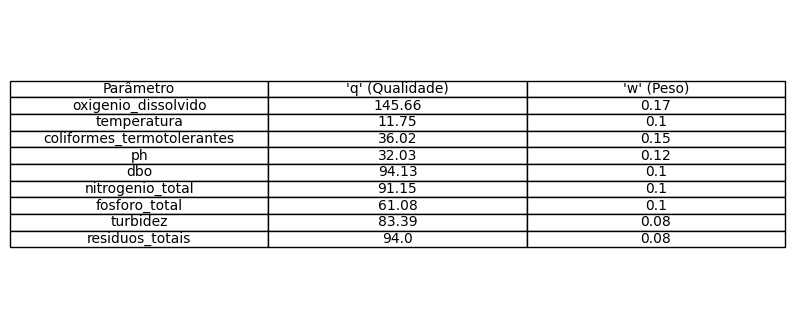

O IQA calculado é: 73.54


In [2]:
import math
import pandas as pd
import matplotlib.pyplot as plt

# Função para calcular a capacidade de saturação de OD em função da temperatura (em °C)
def capacidade_saturacao_od(temperatura):
    OD_SAT = (
        14.652 - 
        (4.1022 * 10**-1 * temperatura) + 
        (7.9910 * 10**-3 * temperatura**2) - 
        (7.7774 * 10**-5 * temperatura**3)
    )
    return OD_SAT

# Função para calcular a capacidade de saturação de OD ajustada para a altitude
def capacidade_saturacao_od_altitude(temperatura, altitude):
    OD_SAT = capacidade_saturacao_od(temperatura)
    OD_SAT_H = OD_SAT * (1 - (altitude / 9450))
    return OD_SAT_H

# Função para calcular a % de saturação de OD
def calcular_percentual_saturacao_od(od_mg_l, temperatura, altitude):
    saturacao_maxima = capacidade_saturacao_od_altitude(temperatura, altitude)
    percentual_saturacao = (od_mg_l / saturacao_maxima) * 100
    return percentual_saturacao

# Função para calcular o 'q' do oxigênio dissolvido (OD) com base na % de saturação
def calcular_q_od(percentual_saturacao):
    if percentual_saturacao <= 50:
        return 0.34 * percentual_saturacao + 0.008095 * percentual_saturacao**2 + 1.35252 * 10**-5 * percentual_saturacao**3 + 3
    elif 50 < percentual_saturacao <= 85:
        return -1.166 * percentual_saturacao + 0.058 * percentual_saturacao**2 - 3.803435 * 10**-4 * percentual_saturacao**3 + 3
    elif 85 < percentual_saturacao <= 100:
        return 3.7745 * percentual_saturacao**0.704889 + 3
    elif 100 < percentual_saturacao <= 140:
        return 2.9 * percentual_saturacao - 0.02496 * percentual_saturacao**2 + 5.60919 * 10**-5 * percentual_saturacao**3 + 50
    else:
        return 3

# Funções para calcular o valor 'q' de cada parâmetro com base nas fórmulas fornecidas
def calcular_q_coliformes(CF):
    if CF == 0:
        return 100
    elif CF <= 10:
        return 100 - 33.5 * math.log10(CF)
    elif CF <= 10**5:
        return 100 - 37.2 * math.log10(CF) + 3.6071 * (math.log10(CF))**2
    else:
        return 3

def calcular_q_ph(pH):
    if pH < 2:
        return 2
    elif 2 <= pH < 6.9:
        return 13.6 * pH - 63.5
    elif 6.9 <= pH <= 7.1:
        return -142.67 * pH**2 + 1073.4 * pH - 1636.4
    elif 7.1 < pH <= 8.5:
        return -7.35 * pH**2 + 101.18 * pH - 311.67
    elif pH > 8.5:
        return 516 - 33.5 * pH
    else:
        return 3

def calcular_q_dbo(DBO):
    if DBO <= 5:
        return 99.96 * math.exp(-0.123772 * DBO)
    elif 5 < DBO <= 15:
        return 104.67 - 31.5463 * math.log(DBO)
    else:
        return 2

def calcular_q_nitrogenio(NT):
    if NT <= 10:
        return 100 - 8.169 * NT - 0.3059 * NT**2
    elif 10 < NT <= 60:
        return 101.9 - 23.1023 * math.log(NT)
    else:
        return 159.31 * math.exp(-0.015124 * NT)

def calcular_q_fosforo(FT):
    if FT <= 1:
        return 99.9 * math.exp(-0.9162 * FT)
    elif 1 < FT <= 5:
        return 57.6 - 20.178 * math.log10(FT)
    else:
        return 19.8 * math.exp(-1.1324 * FT)

def calcular_q_turbidez(UNT):
    if UNT <= 25:
        return 100.17 - 2.67 * UNT + 0.03775 * UNT**2
    elif 25 < UNT <= 100:
        return 84.96 * math.exp(-0.0161 * UNT)
    else:
        return 5

def calcular_q_residuos(ST):
    if ST <= 150:
        return 79.75 + 0.166 * ST - 0.00188 * ST**2
    elif 150 < ST <= 500:
        return 101.67 - 0.13917 * ST
    else:
        return 32

def calcular_q_temperatura():
    return 94

# Função para plotar a tabela de 'q' e 'w'
def plotar_tabela_q_w(parametros, q_values, pesos):
    # Remover 'altitude' pois não tem peso associado
    parametros_sem_altitude = {k: v for k, v in parametros.items() if k != 'altitude'}

    # Arredondar valores de 'q' e pesos para 2 casas decimais
    q_values = [round(q, 2) for q in q_values]
    pesos_arredondados = [round(pesos[param], 2) for param in parametros_sem_altitude.keys()]

    data = {
        "Parâmetro": list(parametros_sem_altitude.keys()),
        "'q' (Qualidade)": q_values,
        "'w' (Peso)": pesos_arredondados
    }

    tabela = pd.DataFrame(data)

    # Plotar a tabela usando matplotlib
    fig, ax = plt.subplots(figsize=(10, 4))  # Define o tamanho da tabela

    ax.axis('tight')
    ax.axis('off')

    # Configurar a tabela para exibir os valores com 2 casas decimais
    ax.table(cellText=tabela.values, colLabels=tabela.columns, cellLoc='center', loc='center')

    plt.show()

# Função principal para calcular o IQA com base nos parâmetros e pesos fornecidos
def calcular_iqa(parametros):
    # Pesos (w) conforme tabela fornecida
    pesos = {
        "oxigenio_dissolvido": 0.17,
        "coliformes_termotolerantes": 0.15,
        "ph": 0.12,
        "dbo": 0.10,
        "nitrogenio_total": 0.10,
        "fosforo_total": 0.10,
        "turbidez": 0.08,
        "residuos_totais": 0.08,
        "temperatura": 0.10
    }

    # Cálculo da % de saturação de OD
    percentual_saturacao_od = calcular_percentual_saturacao_od(parametros["oxigenio_dissolvido"], parametros["temperatura"], parametros["altitude"])

    # Cálculo do 'q' para cada parâmetro
    q_od = calcular_q_od(percentual_saturacao_od)
    q_cf = calcular_q_coliformes(parametros["coliformes_termotolerantes"])
    q_ph = calcular_q_ph(parametros["ph"])
    q_dbo = calcular_q_dbo(parametros["dbo"])
    q_nt = calcular_q_nitrogenio(parametros["nitrogenio_total"])
    q_ft = calcular_q_fosforo(parametros["fosforo_total"])
    q_unt = calcular_q_turbidez(parametros["turbidez"])
    q_st = calcular_q_residuos(parametros["residuos_totais"])
    q_temp = calcular_q_temperatura()

    # Lista de valores 'q' na ordem dos parâmetros (sem altitude)
    q_values = [q_od, q_cf, q_ph, q_dbo, q_nt, q_ft, q_unt, q_st, q_temp]

    # Exibe a tabela de 'q' e 'w'
    plotar_tabela_q_w(parametros, q_values, pesos)

    # Cálculo do IQA como a soma ponderada dos 'q' e 'w'
    iqa = (
        q_od * pesos["oxigenio_dissolvido"] +
        q_cf * pesos["coliformes_termotolerantes"] +
        q_ph * pesos["ph"] +
        q_dbo * pesos["dbo"] +
        q_nt * pesos["nitrogenio_total"] +
        q_ft * pesos["fosforo_total"] +
        q_unt * pesos["turbidez"] +
        q_st * pesos["residuos_totais"] +
        q_temp * pesos["temperatura"]
    )

    return iqa

# Exemplo de uso com os parâmetros de exemplo
parametros = {
    "oxigenio_dissolvido": 10.42,  # OD medido em mg/L
    "temperatura": 14.1,  # Temperatura da água em °C
    "coliformes_termotolerantes": 5000,  # NMP/100 mL
    "ph": 7.15,  # pH
    "dbo": 10.0,  # mg/L
     'altitude': 18, #Altitude H em metros
    "nitrogenio_total": 0.7,  # mg/L
    "fosforo_total": 0.1,  # mg/L
    "turbidez": 20.7,  # NTU
    "residuos_totais": 48  # mg/L
}

# Calcular o IQA
iqa = calcular_iqa(parametros)

print(f"O IQA calculado é: {iqa:.2f}")
